This project was contributed by:
- Hang Tran
- Morgan Lunn
- Tara Perovic

In [1]:
#Set up libraries
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import pandas as pd
import numpy as np
from scipy.stats import gamma
from scipy.integrate import quad
from scipy import integrate
import matplotlib.pyplot as plt
from scipy import stats

Mounted at /content/drive


In [2]:
# Import Data sheet 1 - code 1001
df1 = pd.read_excel('/content/drive/My Drive/VU Ams/Applied Stochastic Modeling/Case study 1/procedures.xlsx',sheet_name='1001')
df2 = pd.read_excel('/content/drive/My Drive/VU Ams/Applied Stochastic Modeling/Case study 1/procedures.xlsx',sheet_name='10020')
# Extract the procedure times in hours and convert to minutes
procedure_times1 = df1['Proc. Time (in hours)'] * 60
procedure_times2 = df2['Proc. Time (in hours)'] * 60

In [3]:
# Method of moments to fit Gamma distribution
def fit_gamma(data):
    mean = np.mean(data)
    variance = np.var(data)
    shape = mean**2 / variance  # k
    scale = variance / mean     # theta
    return shape, scale

In [4]:
# Fit Gamma distribution for both diagnosis codes
shape1, scale1 = fit_gamma(procedure_times1)
shape2, scale2 = fit_gamma(procedure_times2)

print(f"Gamma Parameters for Diagnosis 1001: Shape = {shape1}, Scale = {scale1}")
print(f"Gamma Parameters for Diagnosis 10020: Shape = {shape2}, Scale = {scale2}")

Gamma Parameters for Diagnosis 1001: Shape = 1.5882361700080392, Scale = 67.45593602615949
Gamma Parameters for Diagnosis 10020: Shape = 2.477365098044483, Scale = 85.26309236284946


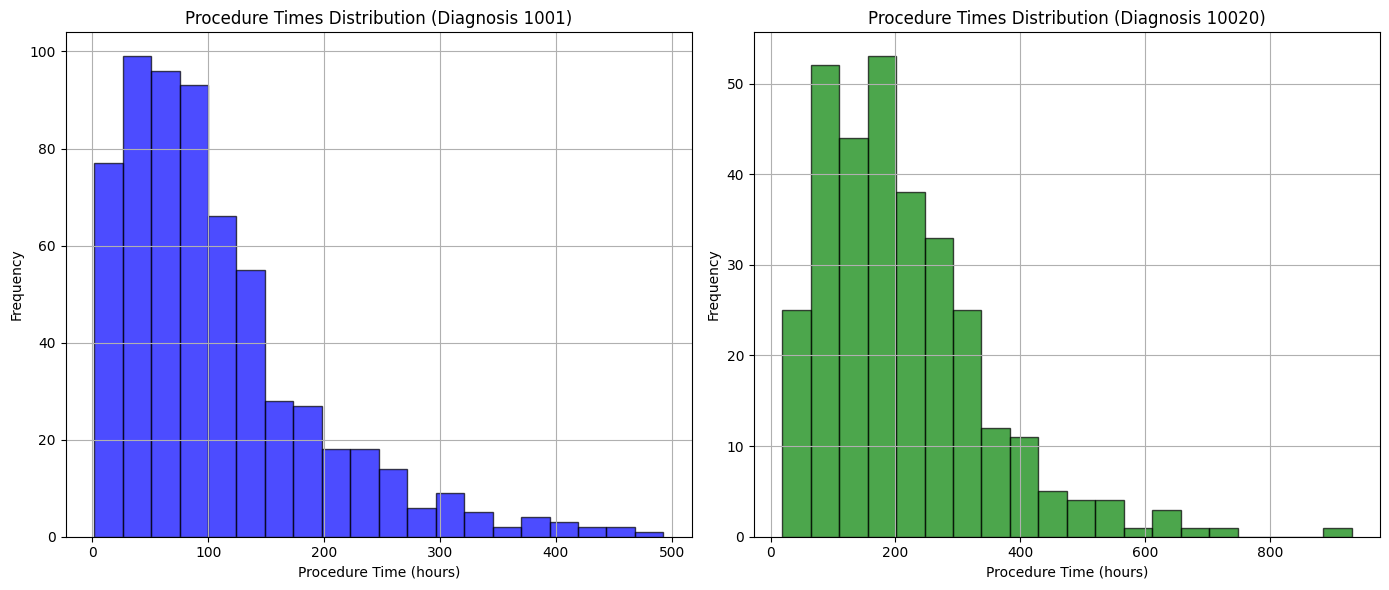

In [5]:
# Plot histograms for both diagnosis codes
plt.figure(figsize=(14, 6))

# Diagnosis 1
plt.subplot(1, 2, 1)
plt.hist(procedure_times1, bins=20, color='blue', edgecolor='black', alpha=0.7)
plt.title('Procedure Times Distribution (Diagnosis 1001)')
plt.xlabel('Procedure Time (hours)')
plt.ylabel('Frequency')
plt.grid(True)

# Diagnosis 2
plt.subplot(1, 2, 2)
plt.hist(procedure_times2, bins=20, color='green', edgecolor='black', alpha=0.7)
plt.title('Procedure Times Distribution (Diagnosis 10020)')
plt.xlabel('Procedure Time (hours)')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()

In [6]:
# Renewal Theory: Expected Number of Procedures
def expected_procedures_renewal(time_limit, shape, scale):
    mean_time = shape * scale  # Mean of the Gamma distribution
    return (time_limit - 480) / mean_time


In [7]:
# Example with time limit x = 960 (16:00)
time_limit = 960
expected_procedures1 = expected_procedures_renewal(time_limit, shape1, scale1)
expected_procedures2 = expected_procedures_renewal(time_limit, shape2, scale2)
print(f"Expected Procedures (Renewal Theory) for diagnosis code 1001 is: {expected_procedures1}")
print(f"Expected Procedures (Renewal Theory) for diagnosis code 10020 is: {expected_procedures2}")

Expected Procedures (Renewal Theory) for diagnosis code 1001 is: 4.48028851654543
Expected Procedures (Renewal Theory) for diagnosis code 10020 is: 2.2724280570995457


In [8]:
# Simulation: Expected Number of Procedures and Overtime
def simulate_procedures(time_limit, shape, scale, num_simulations=1000, confidence_level=0.95):
    procedures_completed = []

    for _ in range(num_simulations):
        time = 480  # Start at 8:00 (in minutes)
        count = 0
        while time < time_limit:
            duration = gamma.rvs(shape, scale=scale)  # Sample from Gamma
            if time + duration <= time_limit:
                time += duration
                count += 1
            else:
                break
        procedures_completed.append(count)

    # Confidence interval for the mean
    mean_procedures = np.mean(procedures_completed)
    sem = stats.sem(procedures_completed)  # Standard error of the mean
    ci = stats.t.interval(confidence_level, len(procedures_completed)-1, loc=mean_procedures, scale=sem)

    return mean_procedures, ci

In [9]:
# Example: Simulate for time limit x = 960 (16:00)
time_limit = 960

# Simulate procedures
mean_procedures_1, ci_procedures_1 = simulate_procedures(time_limit, shape1, scale1)
mean_procedures_2, ci_procedures_2 = simulate_procedures(time_limit, shape2, scale2)

print(f"Diagnosis 1001 - Simulated Procedures: {mean_procedures_1}, CI: {ci_procedures_1}")
print(f"Diagnosis 10020 - Simulated Procedures: {mean_procedures_2}, CI: {ci_procedures_2}")

Diagnosis 1001 - Simulated Procedures: 4.355, CI: (4.251166826425572, 4.458833173574429)
Diagnosis 10020 - Simulated Procedures: 1.94, CI: (1.8802426804133132, 1.9997573195866867)


In [10]:
#Question 2
time_limit = 960
# Renewal Theory: Expected Overtime
def expected_overtime_renewal(time_limit, shape, scale):
    mean_time = shape * scale
    variance_time = shape * (scale**2)
    mean_time_squared = mean_time**2 + variance_time
    return mean_time_squared / (2 * mean_time)

In [11]:
# Example with time limit x = 960 (16:00)
expected_overtime_renewal1 = expected_overtime_renewal(time_limit, shape1, scale1)
expected_overtime_renewal2 = expected_overtime_renewal(time_limit, shape2, scale2)
print(f"Expected Overtime (Renewal Theory) for diagnosis code 1001 is: {expected_overtime_renewal1}")
print(f"Expected Overtime (Renewal Theory) for diagnosis code 10020 is: {expected_overtime_renewal2}")

Expected Overtime (Renewal Theory) for diagnosis code 1001 is: 87.29594675232718
Expected Overtime (Renewal Theory) for diagnosis code 10020 is: 148.24545076695793


In [12]:
t=900 # this value should exceed 480
def ES(shape,scale):
   return shape*scale

def gamsum(n,t,shape,scale):
  return gamma.cdf(t-480, a=n*shape, scale=scale)

def Mt(shape, scale):
  M=0
  for i in range(1,21):
    M += gamsum(i,t,shape,scale)
  return M

def Rt(shape,scale):
   return ES(shape,scale)*(1+Mt(shape,scale))-(t-480)

analytic_overtime1, analytic_overtime2=[], []
analytic_expected_procedures1, analytic_expected_procedures2=[],[]
times = np.arange(480, 960, 30)
for i in times:
  t = i
  #print(f"Mt for shape1, scale1 = {Mt(shape1,scale1)}, t={t}")
  #print(f"Rt for shape1, scale1 = {Rt(shape1,scale1)}, t={t}")
  #print(f"Mt for shape2, scale2 = {Mt(shape2,scale2)}, t={t}")
  #print(f"Rt for shape2, scale2 = {Rt(shape2,scale2)}, t={t}")
  analytic_overtime1.append(Rt(shape1,scale1))
  analytic_overtime2.append(Rt(shape2,scale2))
  analytic_expected_procedures1.append(Mt(shape1,scale1))
  analytic_expected_procedures2.append(Mt(shape2,scale2))


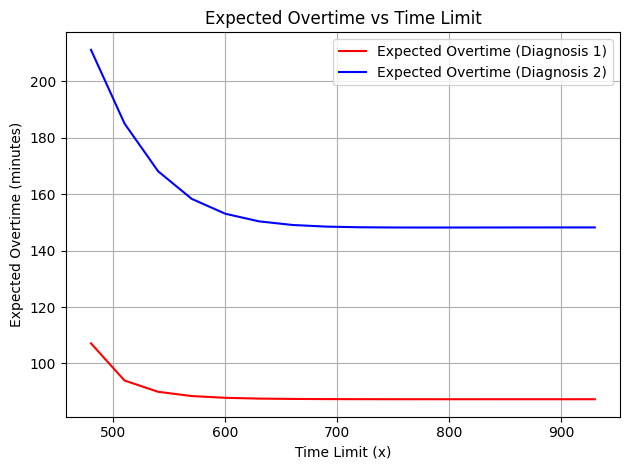

In [13]:
plt.plot(times, analytic_overtime1, label="Expected Overtime (Diagnosis 1)", color='r')
plt.plot(times, analytic_overtime2, label="Expected Overtime (Diagnosis 2)", color='b')
plt.xlabel('Time Limit (x)')
plt.ylabel('Expected Overtime (minutes)')
plt.title('Expected Overtime vs Time Limit')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

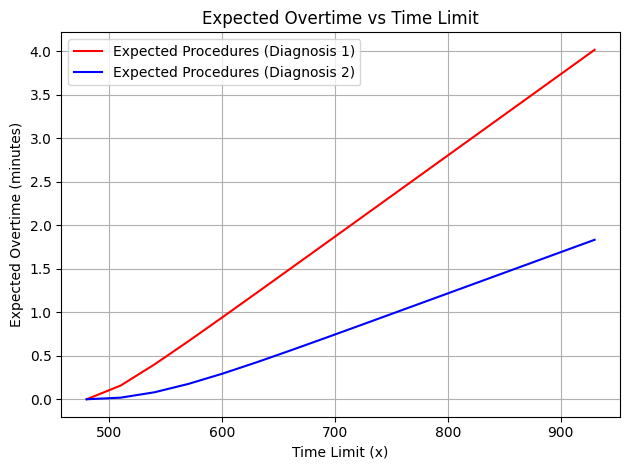

In [14]:
plt.plot(times, analytic_expected_procedures1, label="Expected Procedures (Diagnosis 1)", color='r')
plt.plot(times, analytic_expected_procedures2, label="Expected Procedures (Diagnosis 2)", color='b')
plt.xlabel('Time Limit (x)')
plt.ylabel('Expected Overtime (minutes)')
plt.title('Expected Overtime vs Time Limit')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [15]:
#Simulation for Overtime
def simulate_overtime(time_limit, shape, scale, num_simulations=1000, confidence_level=0.95):
    overtime_list = []

    for _ in range(num_simulations):
        time = 480  # Start at 8:00
        overtime = 0

        while time < time_limit:
            duration = gamma.rvs(shape, scale=scale)  # Sample from Gamma distribution
            if time + duration <= time_limit:
                time += duration  # Procedure finishes before time limit
            else:
                # Procedure starts before time_limit but finishes after -> Overtime
                overtime = max(0, time + duration - time_limit)
                break  # No more procedures can start after this one

        overtime_list.append(overtime)

    # Compute mean and confidence interval for overtime
    mean_overtime = np.mean(overtime_list)
    sem = stats.sem(overtime_list)  # Standard error of the mean
    ci = stats.t.interval(confidence_level, len(overtime_list)-1, loc=mean_overtime, scale=sem)

    return mean_overtime, ci

In [16]:
# Example for x = 16:00
time_limit = 960  # For example, 15:00

# Simulate procedures and overtime for Diagnosis 1
mean_overtime_1, ci_overtime_1 = simulate_overtime(time_limit, shape1, scale1)

print(f"Diagnosis 1001 - Simulated Overtime (x = 16:00): {mean_overtime_1} minutes, CI: {ci_overtime_1}")

# Simulate procedures and overtime for Diagnosis 2
mean_overtime_2, ci_overtime_2 = simulate_overtime(time_limit, shape2, scale2)

print(f"Diagnosis 10020 - Simulated Overtime (x = 16:00): {mean_overtime_2} minutes, CI: {ci_overtime_2}")

Diagnosis 1001 - Simulated Overtime (x = 16:00): 84.46118000840526 minutes, CI: (79.50220835683302, 89.4201516599775)
Diagnosis 10020 - Simulated Overtime (x = 16:00): 156.3395119295845 minutes, CI: (147.900014038302, 164.77900982086697)


In [17]:
# Example for x < 16:00 (e.g., 15:00 = 900 minutes)
time_limit = 900  # For example, 15:00

# Simulate procedures and overtime for Diagnosis 1
mean_overtime_1, ci_overtime_1 = simulate_overtime(time_limit, shape1, scale1)

print(f"Diagnosis 1001 - Simulated Overtime (x = 15:00): {mean_overtime_1} minutes, CI: {ci_overtime_1}")

# Simulate procedures and overtime for Diagnosis 2
mean_overtime_2, ci_overtime_2 = simulate_overtime(time_limit, shape2, scale2)

print(f"Diagnosis 10020 - Simulated Overtime (x = 15:00): {mean_overtime_2} minutes, CI: {ci_overtime_2}")


Diagnosis 1001 - Simulated Overtime (x = 15:00): 87.25224158569553 minutes, CI: (82.01260624127126, 92.4918769301198)
Diagnosis 10020 - Simulated Overtime (x = 15:00): 143.95958206628438 minutes, CI: (136.2105398790072, 151.70862425356157)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2246: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2247: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


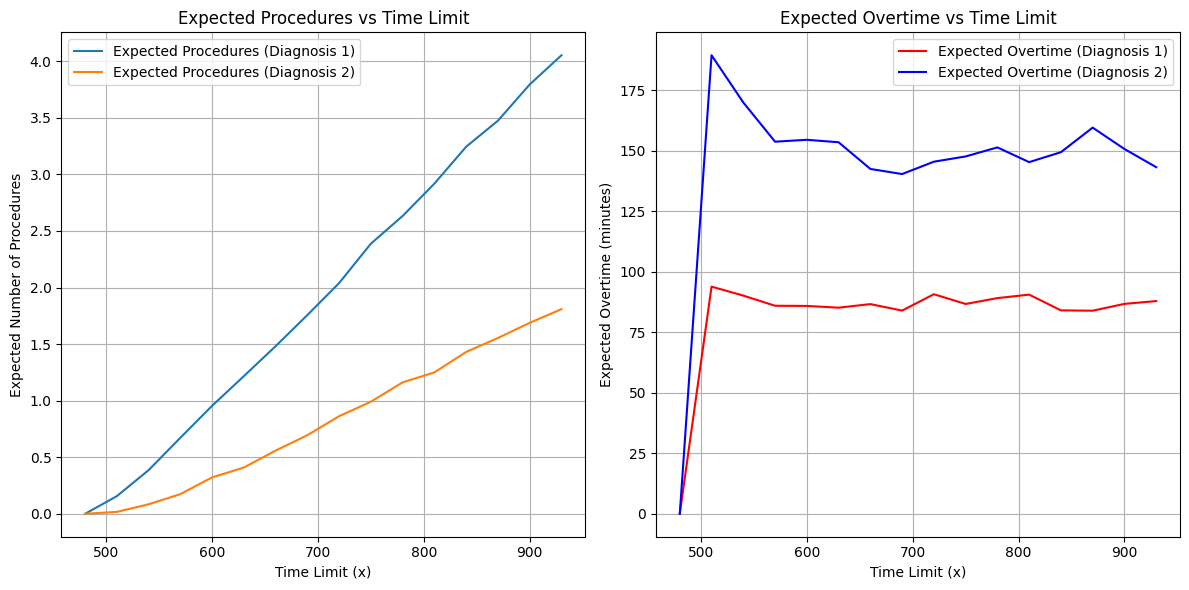

In [18]:
def plot_procedure_overtime(shape1, scale1, shape2, scale2):
    times = np.arange(480, 960, 30)  # Time limits (from 8:00 to 16:00)
    procedures_1, procedures_2 = [], []
    overtime_1, overtime_2 = [], []

    for time_limit in times:
        # Simulate for Diagnosis 1
        proc1, _ = simulate_procedures(time_limit, shape1, scale1)
        overtime1, _ = simulate_overtime(time_limit, shape1, scale1)
        procedures_1.append(proc1)
        overtime_1.append(overtime1)

        # Simulate for Diagnosis 2
        proc2, _ = simulate_procedures(time_limit, shape2, scale2)
        overtime2, _ = simulate_overtime(time_limit, shape2, scale2)
        procedures_2.append(proc2)
        overtime_2.append(overtime2)

    plt.figure(figsize=(12, 6))

    # Expected Procedures
    plt.subplot(1, 2, 1)
    plt.plot(times, procedures_1, label="Expected Procedures (Diagnosis 1)")
    plt.plot(times, procedures_2, label="Expected Procedures (Diagnosis 2)")
    plt.xlabel('Time Limit (x)')
    plt.ylabel('Expected Number of Procedures')
    plt.title('Expected Procedures vs Time Limit')
    plt.legend()
    plt.grid(True)

    # Expected Overtime
    plt.subplot(1, 2, 2)
    plt.plot(times, overtime_1, label="Expected Overtime (Diagnosis 1)", color='r')
    plt.plot(times, overtime_2, label="Expected Overtime (Diagnosis 2)", color='b')
    plt.xlabel('Time Limit (x)')
    plt.ylabel('Expected Overtime (minutes)')
    plt.title('Expected Overtime vs Time Limit')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Visualize the results for both diagnosis codes
plot_procedure_overtime(shape1, scale1, shape2, scale2)
